# Importações

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.neighbors import NearestNeighbors
from functools import partial


Métodos de Clusterização

In [162]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift

# Funções

In [163]:
def funcDataFrame(info, df_clusters):
    nova_linha_df = pd.DataFrame([info], columns=df_clusters.columns)

    df_clusters = pd.concat([df_clusters, nova_linha_df], ignore_index=True)
    
    return df_clusters

# DataFrame

In [164]:
df_original = pd.read_excel('../dados/df.xlsx',)
df = df_original.copy()
df

,euexfreq,eugenhth,eufastfdfrq,eudietsoda,euwgt,euhgt
0,0,1,0,0,77.11,1.52
1,0,2,1,0,58.06,1.60
2,0,5,0,0,122.47,1.57
3,5,4,0,0,95.25,1.75
4,2,3,3,1,99.79,1.80
...,...,...,...,...,...,...
10552,5,3,0,0,67.59,1.57
10553,2,2,3,2,81.65,1.73
10554,2,1,4,0,64.41,1.70
10555,1,1,3,1,76.20,1.80


## Métrica

In [165]:
from sklearn.metrics import make_scorer, silhouette_score,calinski_harabasz_score,davies_bouldin_score


In [166]:
def score_composto(X, labels):
    # Coeficiente de Silhueta normalizado
    sil_score = silhouette_score(X, labels)
    sil_score_norm = (sil_score + 1) / 2

    # Índice de Davies-Bouldin normalizado (inverso)
    db_score = davies_bouldin_score(X, labels)
    db_score_norm = 1 / (1 + db_score)

    # Índice de Calinski-Harabasz normalizado (log transformado)
    ch_score = calinski_harabasz_score(X, labels)
    ch_score_log = np.log(1 + ch_score)
    ch_score_norm = ch_score_log / (1 + ch_score_log)

    # Cálculo do score composto
    score_composto = (sil_score_norm + db_score_norm + ch_score_norm) / 3

    return score_composto


## Clusterizações

### Variações dos Hiperparâmetros

#### Número de Clusters (AgglomerativeClustering e KMeans)

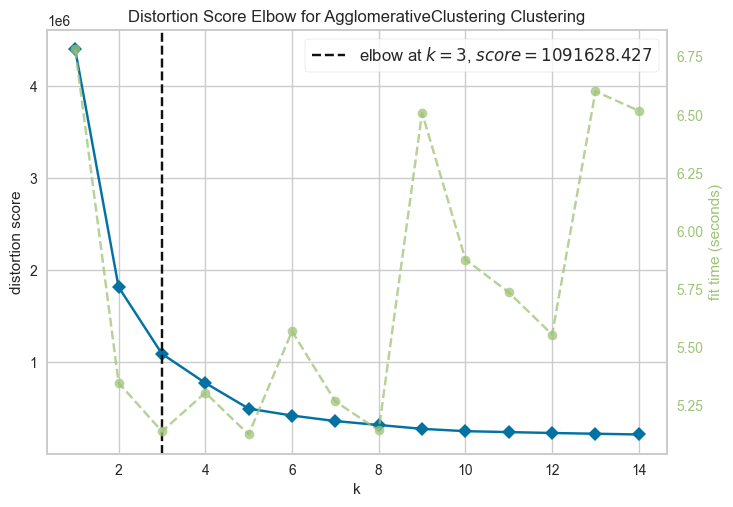

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [167]:
#distorção: média das distâncias quadradas dos centros dos clusters dos respectivos clusters
grafico = KElbowVisualizer(AgglomerativeClustering(), k=(1,15))

grafico.fit(df)        
grafico.show()

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

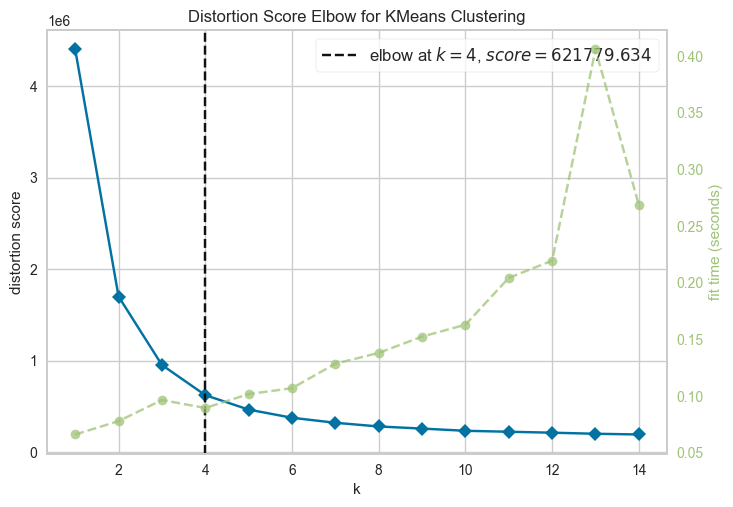

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [168]:
#distorção: média das distâncias quadradas dos centros dos clusters dos respectivos clusters
grafico = KElbowVisualizer(KMeans(), k=(1,15))

grafico.fit(df)        
grafico.show()  

Vou considerar até 7 clusters nos dois algorítmos

#### Escolha do eps (DBSCAN)

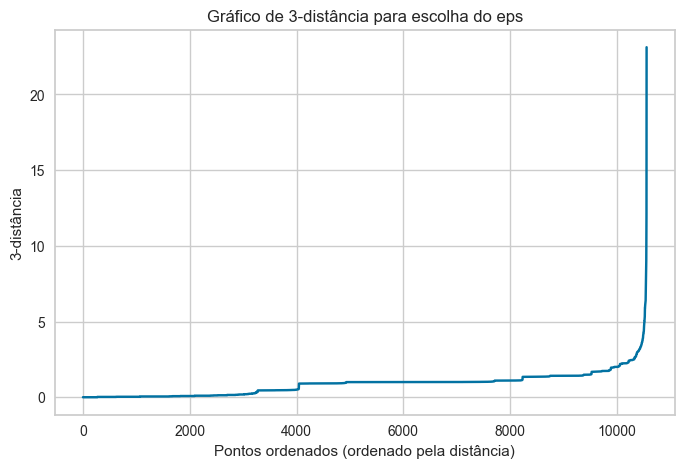

In [169]:
k = 3  # Escolha um valor de k, geralmente >= número de dimensões + 1

# Calcular as k distâncias mais próximas
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

# Ordenar as distâncias para plotar o gráfico de k-distância
distances = np.sort(distances[:, k - 1], axis=0)

# Plotar o gráfico de k-distância
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Pontos ordenados (ordenado pela distância)")
plt.ylabel(f"{k}-distância")
plt.title(f"Gráfico de {k}-distância para escolha do eps")
plt.grid(True)
plt.show()

Cerca de 2 a 5 para eps

#### Encontrar Valores Próximos do bandwidth (mean-shift)

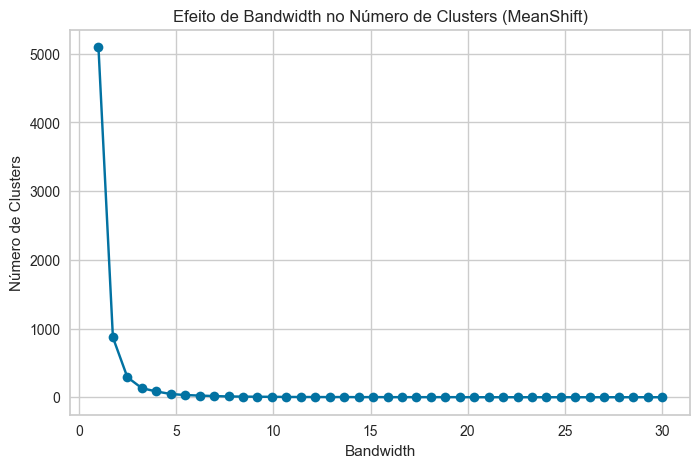

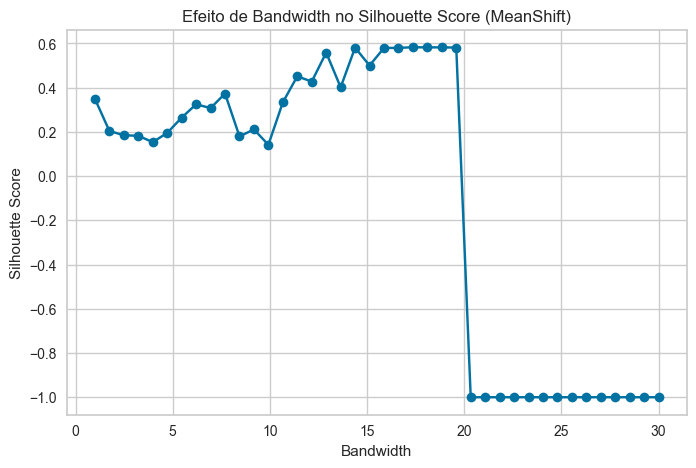

In [170]:
bandwidth_values = np.linspace(1, 30, 40)
n_clusters_list = []
silhouette_scores = []

for bandwidth in bandwidth_values:
    meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = meanshift.fit_predict(df)
    n_clusters = len(np.unique(labels))
    n_clusters_list.append(n_clusters)
    if n_clusters > 1:
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)

plt.figure(figsize=(8, 5))
plt.plot(bandwidth_values, n_clusters_list, marker='o')
plt.xlabel('Bandwidth')
plt.ylabel('Número de Clusters')
plt.title('Efeito de Bandwidth no Número de Clusters (MeanShift)')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(bandwidth_values, silhouette_scores, marker='o')
plt.xlabel('Bandwidth')
plt.ylabel('Silhouette Score')
plt.title('Efeito de Bandwidth no Silhouette Score (MeanShift)')
plt.show()

Valores após 10 até 20

In [171]:
def objective(trial, X, clustering_algorithm):

    if clustering_algorithm == 'kmeans':
        n_clusters = trial.suggest_int('n_clusters', 2, 7)
        init = trial.suggest_categorical('init', ['k-means++', 'random'])
        n_init = trial.suggest_int('n_init', 10, 300, step=10)
        max_iter = trial.suggest_int('max_iter', 100, 1000, step=50)
        tol = trial.suggest_float('tol', 1e-6, 1e-1, log=True)
        algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])
        model = KMeans(
            n_clusters=n_clusters,
            init=init,
            n_init=n_init,
            max_iter=max_iter,
            tol=tol,
            algorithm=algorithm,
            random_state=42
        )

    elif clustering_algorithm == 'dbscan':
        eps = trial.suggest_float('eps', 2.0, 5.0, step=0.5)
        min_samples = trial.suggest_int('min_samples', 1500,3000 ,step=100)
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
        algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        leaf_size = trial.suggest_int('leaf_size', 10, 100, step=10)
        p = trial.suggest_float('p', 1.0, 5.0)
        model = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric=metric,
            algorithm=algorithm,
            leaf_size=leaf_size,
            p=p
        )

    elif clustering_algorithm == 'agglomerative':

        n_clusters = trial.suggest_int('n_clusters', 2, 7)
        compute_full_tree = trial.suggest_categorical('compute_full_tree', ['auto', True, False])

        linkage = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])
        if linkage == 'ward':
            metric = 'euclidean'
        else:
            metric = trial.suggest_categorical('metric', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'])
        
        model = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage,
            affinity=metric,
            compute_full_tree=compute_full_tree,
        )



    elif clustering_algorithm == 'mean_shift':
        bandwidth = trial.suggest_float('bandwidth', 10, 20.0, step=1.0)
        bin_seeding = trial.suggest_categorical('bin_seeding', [True, False])
        min_bin_freq = trial.suggest_int('min_bin_freq', 10, 150, step=10)
        cluster_all = trial.suggest_categorical('cluster_all', [True, False])
        model = MeanShift(
            bandwidth=bandwidth,
            bin_seeding=bin_seeding,
            min_bin_freq=min_bin_freq,
            cluster_all=cluster_all
        )

    else:
        raise ValueError("Algoritmo de clusterização não suportado.")


    # Ajustar o modelo e prever as labels
    labels = model.fit_predict(X)

    # Verificar se todos os pontos foram classificados no mesmo cluster
    if len(np.unique(labels)) <= 1:
        return -np.inf  # Retorna um valor muito baixo se a clusterização não for válida

    # Calcular o score composto
    score = score_composto(X, labels)

    return score


In [172]:
def otimizar_clustering(X, clustering_algorithm, n_trials=50):
    study = optuna.create_study(direction='maximize')

    # Definir a função objetivo parcial com o algoritmo de clusterização fixado

    objective_func = partial(objective, X=X, clustering_algorithm=clustering_algorithm)
    
    # Executar a otimização
    study.optimize(objective_func, n_trials=n_trials)

    # Melhor conjunto de hiperparâmetros
    best_params = study.best_params
    best_score = study.best_value

    print(f"\nMelhores hiperparâmetros para {clustering_algorithm}:")
    print(best_params)
    print(f"Melhor score composto: {best_score}")

    return study

In [173]:
print("Otimização do K-Means:")
study_kmeans = otimizar_clustering(df, 'kmeans', n_trials=100)


[I 2024-10-29 13:26:58,992] A new study created in memory with name: no-name-faa2d935-abbf-42fb-bdd0-ac6fa75b4a5f


Otimização do K-Means:


[I 2024-10-29 13:27:02,595] Trial 0 finished with value: 0.7226426990002129 and parameters: {'n_clusters': 7, 'init': 'random', 'n_init': 80, 'max_iter': 450, 'tol': 7.4229168116695395e-06, 'algorithm': 'lloyd'}. Best is trial 0 with value: 0.7226426990002129.
[I 2024-10-29 13:27:08,950] Trial 1 finished with value: 0.7512537039433016 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 270, 'max_iter': 650, 'tol': 4.357971748638071e-06, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.7512537039433016.
[I 2024-10-29 13:27:14,135] Trial 2 finished with value: 0.7363894117620369 and parameters: {'n_clusters': 5, 'init': 'k-means++', 'n_init': 170, 'max_iter': 250, 'tol': 0.0022787470137081134, 'algorithm': 'elkan'}. Best is trial 1 with value: 0.7512537039433016.
[I 2024-10-29 13:27:17,800] Trial 3 finished with value: 0.7454851410954048 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 40, 'max_iter': 550, 'tol': 1.4839811077611051e-06, 'algorithm': 'elkan'}. B


Melhores hiperparâmetros para kmeans:
{'n_clusters': 2, 'init': 'k-means++', 'n_init': 260, 'max_iter': 150, 'tol': 0.00038896623333968593, 'algorithm': 'lloyd'}
Melhor score composto: 0.7605901617573169


In [174]:
print("\nOtimização do DBSCAN:")
study_dbscan = otimizar_clustering(df, 'dbscan', n_trials=100)


[I 2024-10-29 13:35:01,585] A new study created in memory with name: no-name-cfa853fa-648d-4c0a-9cc4-fb6ded2c8d87



Otimização do DBSCAN:


[I 2024-10-29 13:35:03,209] Trial 0 finished with value: -inf and parameters: {'eps': 3.0, 'min_samples': 2000, 'metric': 'chebyshev', 'algorithm': 'brute', 'leaf_size': 100, 'p': 3.040380576287224}. Best is trial 0 with value: -inf.
[I 2024-10-29 13:35:04,103] Trial 1 finished with value: -inf and parameters: {'eps': 4.5, 'min_samples': 2200, 'metric': 'manhattan', 'algorithm': 'brute', 'leaf_size': 50, 'p': 1.1007569087351943}. Best is trial 0 with value: -inf.
[I 2024-10-29 13:35:04,432] Trial 2 finished with value: -inf and parameters: {'eps': 3.0, 'min_samples': 1500, 'metric': 'euclidean', 'algorithm': 'brute', 'leaf_size': 90, 'p': 4.514447577604971}. Best is trial 0 with value: -inf.
[I 2024-10-29 13:35:04,799] Trial 3 finished with value: -inf and parameters: {'eps': 3.0, 'min_samples': 1500, 'metric': 'manhattan', 'algorithm': 'auto', 'leaf_size': 80, 'p': 1.946157488393145}. Best is trial 0 with value: -inf.
[I 2024-10-29 13:35:17,343] Trial 4 finished with value: 0.63069800


Melhores hiperparâmetros para dbscan:
{'eps': 5.0, 'min_samples': 1800, 'metric': 'chebyshev', 'algorithm': 'brute', 'leaf_size': 70, 'p': 2.858413771810197}
Melhor score composto: 0.6873803630427098


In [175]:
print("\nOtimização do Agglomerative Clustering:")
study_agglomerative = otimizar_clustering(df, 'agglomerative', n_trials=100)


[I 2024-10-29 13:41:55,402] A new study created in memory with name: no-name-4e93d426-7f79-4c9b-aa41-5e0059e86def
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead




Otimização do Agglomerative Clustering:


[I 2024-10-29 13:42:06,063] Trial 0 finished with value: 0.709556971388603 and parameters: {'n_clusters': 6, 'compute_full_tree': True, 'linkage': 'ward'}. Best is trial 0 with value: 0.709556971388603.
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

[I 2024-10-29 13:42:15,559] Trial 1 finished with value: 0.5276973991090959 and parameters: {'n_clusters': 7, 'compute_full_tree': False, 'linkage': 'average', 'metric': 'cosine'}. Best is trial 0 with value: 0.709556971388603.
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

[I 2024-10-29 13:42:24,908] Trial 2 finished with value: 0.5908363119493621 and par


Melhores hiperparâmetros para agglomerative:
{'n_clusters': 3, 'compute_full_tree': True, 'linkage': 'average', 'metric': 'manhattan'}
Melhor score composto: 0.7841728549555228


In [177]:
print("\nOtimização do Mean-Shift:")
study_meanshift = otimizar_clustering(df, 'mean_shift', n_trials=20)


[I 2024-10-29 14:27:06,403] A new study created in memory with name: no-name-07efcb9e-1067-47c3-8743-b9b310349d16



Otimização do Mean-Shift:


[I 2024-10-29 14:28:54,802] Trial 0 finished with value: 0.6840113812045326 and parameters: {'bandwidth': 16.0, 'bin_seeding': False, 'min_bin_freq': 100, 'cluster_all': False}. Best is trial 0 with value: 0.6840113812045326.
[I 2024-10-29 14:30:24,070] Trial 1 finished with value: 0.6299361493769005 and parameters: {'bandwidth': 12.0, 'bin_seeding': False, 'min_bin_freq': 40, 'cluster_all': False}. Best is trial 0 with value: 0.6840113812045326.
[I 2024-10-29 14:30:26,056] Trial 2 finished with value: 0.5609212185920923 and parameters: {'bandwidth': 11.0, 'bin_seeding': True, 'min_bin_freq': 100, 'cluster_all': False}. Best is trial 0 with value: 0.6840113812045326.
[I 2024-10-29 14:31:26,586] Trial 3 finished with value: 0.7885092500475094 and parameters: {'bandwidth': 19.0, 'bin_seeding': False, 'min_bin_freq': 120, 'cluster_all': True}. Best is trial 3 with value: 0.7885092500475094.
[I 2024-10-29 14:31:26,685] Trial 4 finished with value: -inf and parameters: {'bandwidth': 18.0, '


Melhores hiperparâmetros para mean_shift:
{'bandwidth': 18.0, 'bin_seeding': False, 'min_bin_freq': 70, 'cluster_all': True}
Melhor score composto: 0.7886922301105387


## Classificação

### K-Means

In [178]:
kmeans = KMeans(**study_kmeans.best_params).fit(df)
labels = kmeans.labels_
labels

array([1, 1, 0, ..., 1, 1, 1])

In [179]:
df_kmeans = df.copy()
df_kmeans['Clusters'] = labels
df_kmeans

,euexfreq,eugenhth,eufastfdfrq,eudietsoda,euwgt,euhgt,Clusters
0,0,1,0,0,77.11,1.52,1
1,0,2,1,0,58.06,1.60,1
2,0,5,0,0,122.47,1.57,0
3,5,4,0,0,95.25,1.75,0
4,2,3,3,1,99.79,1.80,0
...,...,...,...,...,...,...,...
10552,5,3,0,0,67.59,1.57,1
10553,2,2,3,2,81.65,1.73,1
10554,2,1,4,0,64.41,1.70,1
10555,1,1,3,1,76.20,1.80,1


In [180]:
optuna.visualization.plot_optimization_history(study_kmeans)

### DBSCAN

In [181]:
dbscan = DBSCAN(**study_dbscan.best_params).fit(df)
labels = dbscan.labels_
labels

array([ 0,  0, -1, ...,  0,  0,  0], dtype=int64)

In [182]:
df_dbscan = df.copy()
df_dbscan['Clusters'] = labels
df_dbscan

,euexfreq,eugenhth,eufastfdfrq,eudietsoda,euwgt,euhgt,Clusters
0,0,1,0,0,77.11,1.52,0
1,0,2,1,0,58.06,1.60,0
2,0,5,0,0,122.47,1.57,-1
3,5,4,0,0,95.25,1.75,-1
4,2,3,3,1,99.79,1.80,-1
...,...,...,...,...,...,...,...
10552,5,3,0,0,67.59,1.57,0
10553,2,2,3,2,81.65,1.73,0
10554,2,1,4,0,64.41,1.70,0
10555,1,1,3,1,76.20,1.80,0


In [183]:
df_dbscan['Clusters'].value_counts()

 0    7447
-1    3110
Name: Clusters, dtype: int64

In [184]:
optuna.visualization.plot_optimization_history(study_dbscan)

In [185]:
optuna.visualization.plot_param_importances(study_dbscan)

[W 2024-10-29 15:05:55,648] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,649] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,650] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,651] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,651] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,652] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,652] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,653] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,653] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:55,654] Trial 1

In [186]:
optuna.visualization.plot_slice(study_dbscan)

[W 2024-10-29 15:05:56,166] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,167] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,168] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,168] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,169] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,169] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,170] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,170] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,170] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:05:56,171] Trial 1

### Agglomerative Clustering

In [187]:
b = study_agglomerative.best_params
b['n_clusters'] = None
b

{'n_clusters': None,
 'compute_full_tree': True,
 'linkage': 'average',
 'metric': 'manhattan'}

In [188]:
agglomerative = AgglomerativeClustering(**study_agglomerative.best_params).fit(df)
labels = agglomerative.labels_
labels

array([0, 0, 2, ..., 0, 0, 0], dtype=int64)

In [189]:
df_agglomerative = df.copy()
df_agglomerative['Clusters'] = labels
df_agglomerative

,euexfreq,eugenhth,eufastfdfrq,eudietsoda,euwgt,euhgt,Clusters
0,0,1,0,0,77.11,1.52,0
1,0,2,1,0,58.06,1.60,0
2,0,5,0,0,122.47,1.57,2
3,5,4,0,0,95.25,1.75,0
4,2,3,3,1,99.79,1.80,0
...,...,...,...,...,...,...,...
10552,5,3,0,0,67.59,1.57,0
10553,2,2,3,2,81.65,1.73,0
10554,2,1,4,0,64.41,1.70,0
10555,1,1,3,1,76.20,1.80,0


In [190]:
optuna.visualization.plot_optimization_history(study_agglomerative)

In [191]:
optuna.visualization.plot_param_importances(study_agglomerative)

In [192]:
optuna.visualization.plot_slice(study_agglomerative)

### Mean-Shift

In [193]:
meanshift = MeanShift(**study_meanshift.best_params).fit(df)
labels = meanshift.labels_
labels

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [194]:
df_meanshift = df.copy()
df_meanshift['Clusters'] = labels
df_meanshift

,euexfreq,eugenhth,eufastfdfrq,eudietsoda,euwgt,euhgt,Clusters
0,0,1,0,0,77.11,1.52,0
1,0,2,1,0,58.06,1.60,0
2,0,5,0,0,122.47,1.57,1
3,5,4,0,0,95.25,1.75,0
4,2,3,3,1,99.79,1.80,0
...,...,...,...,...,...,...,...
10552,5,3,0,0,67.59,1.57,0
10553,2,2,3,2,81.65,1.73,0
10554,2,1,4,0,64.41,1.70,0
10555,1,1,3,1,76.20,1.80,0


In [195]:
optuna.visualization.plot_optimization_history(study_meanshift)

In [196]:
optuna.visualization.plot_param_importances(study_meanshift)

[W 2024-10-29 15:07:37,538] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:07:37,539] Trial 9 is omitted in visualization because its objective value is inf or nan.


In [197]:
optuna.visualization.plot_slice(study_meanshift)

[W 2024-10-29 15:07:37,854] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-29 15:07:37,857] Trial 9 is omitted in visualization because its objective value is inf or nan.


### Exportações das Bases com Clusters

In [198]:
df_kmeans.to_excel('..\dados\df_kmeans.xlsx', index=False)
df_dbscan.to_excel('..\dados\df_dbscan.xlsx', index=False)
df_agglomerative.to_excel('..\dados\df_agglomerative.xlsx', index=False)
df_meanshift.to_excel('..\dados\df_meanshift.xlsx', index=False)
